# Train XGBoost model with Weights on Time

In [19]:
import xgboost
import sklearn
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model_selection import OptunaCVOptimizer, TimeSeriesDailyRollingSplit
from quantbullet.model import LastValueEstimator, TypicalHyperparameterRanges
from quantbullet.model import TimeWeightedXGBRegressor

In [10]:
# Load the sunspots dataset
sunspots = sm.datasets.sunspots.load_pandas().data

# Create a new feature by shifting the sunspots count
sunspots['lagged_sunspots'] = sunspots['SUNACTIVITY'].shift(1)


# Drop the first row which will have a NaN value in the 'lagged_sunspots' column
sunspots = sunspots.iloc[1:]

# Reset the index and rename the column
sunspots_reset = sunspots.reset_index().rename(columns={'index': 'date'})

X = sunspots_reset[['YEAR', 'date', 'lagged_sunspots']]
y = sunspots_reset['SUNACTIVITY']

In [11]:
X.head()

,YEAR,date,lagged_sunspots
0,1701.0,1,5.0
1,1702.0,2,11.0
2,1703.0,3,16.0
3,1704.0,4,23.0
4,1705.0,5,36.0


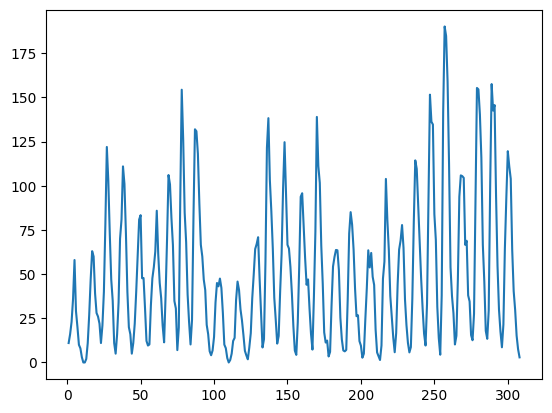

In [12]:
plt.plot(X['date'], y)

## XGBoost Model

Next, we try to use XGBoost to do the same task. An optuna study is used to find the best hyperparameters for the model.

- `objective`: is the xgboost objective function used in training.
- `scoring`: is the scoring function for the cross validation (in our case the backtesting) used by `scikit-learn`.

In [13]:
tuning_params = TypicalHyperparameterRanges.xgboost
tuning_params['max_depth'].insert(0, 1)
tuning_params['n_estimators'].insert(0, 2)

In [14]:
ts_split = list(TimeSeriesDailyRollingSplit(min_train_size=200).split(X))
optimizer = OptunaCVOptimizer(
    X=X,
    y=y,
    model=xgboost.XGBRegressor(random_state=42),
    cv=ts_split,
    objective="reg:absoluteerror",
    scoring="neg_mean_absolute_error",
)

In [15]:
optimizer.optimize(
    fixed_params={},
    tuning_params=tuning_params,
    n_trials=5)

Best trial: 1. Best value: -26.6497: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


In this tiny dataset, the XGBoost model is not better than the Last Value Estimator. The feature is too simple.

In [20]:
model = TimeWeightedXGBRegressor(
    reference_column='date',
)

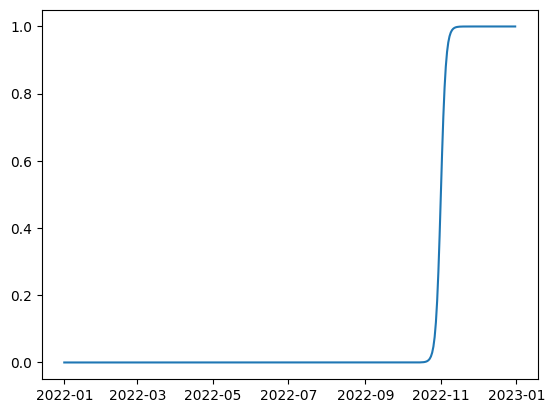

In [23]:
import pandas as pd

# Generate a date range
dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Create a DataFrame
X = pd.DataFrame({'date': dates})

def logistic_weights(dates, decay_rate, offset_days):
    # Calculate the number of days from the most recent date
    days = (dates.max() - dates).dt.days

    # Calculate weights using a logistic function
    weights = 1 / (1 + np.exp(decay_rate * (days - offset_days)))

    return weights

# Use the function to calculate weights
decay_rate = 0.5  # Adjust this value to change the rate of decay
offset_days = 60  # Adjust this value to change the point where the weights start to decrease
weights = logistic_weights(X['date'], decay_rate, offset_days)

# Plot the weights
plt.plot(X['date'], weights)
plt.show()